# PDAN8412 – Part 2: Logistic Regression
### Author: Maximilian Walsh | Student No: ST10203070
### Module: Programming for Data Analytics 2

---

### Import Libraries and Load Dataset

#### To start, we import essential libraries for data analysis and load the dataset into a Spark DataFrame.

In [1]:
# === Package Setup & Imports for Part 2 (Logistic Regression) ===
import importlib, sys, subprocess

# Helper function: install if missing
def ensure(pkg, version=None):
    try:
        importlib.import_module(pkg)
        print(f"{pkg} already available")
    except ImportError:
        spec = f"{pkg}=={version}" if version else pkg
        print(f"Installing {spec} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", spec])

# Ensure core dependencies
ensure("pyspark", "3.5.1")
ensure("pandas")
ensure("numpy")
ensure("scikit-learn")
ensure("matplotlib")
ensure("seaborn")

# === Imports ===
import pyspark
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, confusion_matrix,
                             classification_report)

# Confirm versions
print("PySpark:", pyspark.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
print("Imports and environment ready.")


pyspark already available
pandas already available
numpy already available
Installing scikit-learn ...
matplotlib already available
seaborn already available
PySpark: 3.5.1
scikit-learn: 1.5.1
Imports and environment ready.


In [2]:
# === Initialise Spark Session ===
from pyspark.sql import SparkSession

# Create or reuse Spark session
spark = (
    SparkSession.builder
        .appName("PDAN8412-Part2-LogisticRegression")
        .config("spark.ui.showConsoleProgress", "false")
        .getOrCreate()
)

print(f"Spark session initialised (version {spark.version})")

# === Load the dataset ===
file_path = "books_1.Best_Books_Ever.csv"

# Read CSV into Spark DataFrame with inferred schema and header row
books_df = (
    spark.read
         .option("header", "true")
         .option("inferSchema", "true")
         .csv(file_path)
)

# Confirm basic structure
print(f"Dataset successfully loaded: {books_df.count():,} records, {len(books_df.columns)} columns")
books_df.printSchema()
books_df.show(5, truncate=False)


Spark session initialised (version 3.5.1)
Dataset successfully loaded: 60,475 records, 25 columns
root
 |-- bookId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- series: string (nullable = true)
 |-- author: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- description: string (nullable = true)
 |-- language: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- characters: string (nullable = true)
 |-- bookFormat: string (nullable = true)
 |-- edition: string (nullable = true)
 |-- pages: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- publishDate: string (nullable = true)
 |-- firstPublishDate: string (nullable = true)
 |-- awards: string (nullable = true)
 |-- numRatings: string (nullable = true)
 |-- ratingsByStars: string (nullable = true)
 |-- likedPercent: string (nullable = true)
 |-- setting: string (nullable = true)
 |-- coverImg: string (nullable = true)
 |-- bbeSc

## Data Inspection Block

### Analytical Plan (Logistic Regression)

This Jupyter notebook builds a logistic regression model to predict whether a book will be a best seller, using the Best Books Ever dataset. Spark is used for ingest, cleaning, and EDA at scale; scikit-learn is used for modeling. The key steps to be conducted are:

1. **Data Loading and Integrity Check (Spark)** – Load the CSV with schema interface. Inspect the shape, schema, and basic summaries. Remove exact duplicates, trim obvious test noise like whitespace, and handle missing/invalid values. 
2. **Target Definition (Label Engineering)** – Create a binary target 'bestseller' based on rader engagement. The baseline approach being to label as 1 if 'numRatings' is greater than or equal to the 80th percentile (11,166), otheriwse label as 0. Verify the class balance after labeling. 
3. **Exploratory Data Analysis (EDA)** – Check the distributions of 'rating', 'numRatings', 'bbeScore', and 'likedPercent'. Look at correlations among numeric variables and the bestseller label. Assess the genre and language frequency to understand categorical diversity.
4. **Feature Preparation (for Logistic Regression)** - Numeric features 'rating', 'numRatings', 'bbeScore', 'likedPercent', 'price' will be scaled using StandardScaler. Categorical features like 'language', 'publisher', and 'genres' will be encoded using OneHotEncoder(handle_uknown="ignore"). 
4. **Train/Validation/Test Split** - Split the data into train/validation/test with a 70/15/15 respective split with stratification on the new 'bestseller' label.
5. **Model Training (scikit-learn)** – Train LogisticRegression with regularisation. Use class_weight='balanced' if classes are skewed.
6. **Evaluation and Interpretation** – Assess model performance using accuracy, precision, recall, macro F1-score, ROC-AUC, confusion matrices and ROC curve. Interpret coefficients, top positive/negative drivers, for explainability.
7. **Hyperparameter Tuning and Retraining** – Grid/random searrch over C (regularisation strength), penality (L1/L2), and feature options. Retraing on train + valid with best parameters and re-evaluate on test. 
8. **Conclusion** – Summarise predictive performance, key drivers of best seller, and next steps like feature enrichment, threshold tuning,calibration. 

In [ ]:
# === Clean + Prepare "Best Books Ever" Dataset for Logistic Regression ===
from pyspark.sql import functions as F
from pyspark.sql import types as T

df = books_df  

# --- Select relevant columns ---
keep_cols = [
    "bookId", "title", "author", "language", "rating", "numRatings",
    "likedPercent", "bbeScore", "bbeVotes", "price", "genres", "publisher"
]
df = df.select(*[c for c in keep_cols if c in df.columns])
print(f"Columns selected: {df.columns}")

# --- Convert numeric columns to double ---
numeric_cols = ["rating", "numRatings", "likedPercent", "bbeScore", "bbeVotes", "price"]
for col in numeric_cols:
    if col in df.columns:
        df = df.withColumn(col, F.col(col).cast(T.DoubleType()))

# --- Deduplicate and basic hygiene ---
before = df.count()
df = (
    df.dropDuplicates(["bookId"])
      .dropna(subset=["numRatings", "rating"])
      .filter(F.col("numRatings") > 0)
)
after = df.count()
print(f"Rows after cleaning: {after:,} (removed {before - after:,})")

# --- Create binary target variable 'bestseller' ---
# Define bestseller as top 20% of books by numRatings
p80 = df.approxQuantile("numRatings", [0.8], 0.01)[0]
print(f"Bestseller threshold (80th percentile of numRatings): {p80:,.0f}")

df = df.withColumn("bestseller", (F.col("numRatings") >= F.lit(p80)).cast("int"))

# --- Add basic readability features ---
df = (
    df.withColumn("title_length", F.length(F.col("title")))
      .withColumn("genre_count", F.size(F.split(F.regexp_replace(F.col("genres"), "[\\[\\]']", ""), ",")))
)

# --- Quick inspection ---
print("Row count:", df.count())
df.groupBy("bestseller").count().orderBy("bestseller").show()

# Preview key info
preview_cols = ["title", "author", "rating", "numRatings", "likedPercent", "bestseller"]
df.select(*preview_cols).show(5, truncate=80)

# Cache prepared dataset for downstream modelling
books_df_prepared = df.cache()


Columns selected: ['bookId', 'title', 'author', 'language', 'rating', 'numRatings', 'likedPercent', 'bbeScore', 'bbeVotes', 'price', 'genres', 'publisher']
Rows after cleaning: 41,103 (removed 19,372)
Bestseller threshold (80th percentile of numRatings): 11,166
Row count: 41103
+----------+-----+
|bestseller|count|
+----------+-----+
|         0|32530|
|         1| 8573|
+----------+-----+

+--------------------------------------------------+--------------------------------------------------------------------------+------+----------+------------+----------+
|                                             title|                                                                    author|rating|numRatings|likedPercent|bestseller|
+--------------------------------------------------+--------------------------------------------------------------------------+------+----------+------------+----------+
|                                  As a Driven Leaf|                                  Milton Ste

## 1. Justification of Dataset Choice

The selected dataset is the Best Books Ever dataset from Kaggle, containing over 60,000 records of books with features like title, author, rating, number of ratings, language, price, and genre. Post cleaning and deduplication, 41,103 unqiue records remained, which comfortably exceedes the project minimum of 10,000 entries. 

- **Relevance to the Task**:  
  The dataset aligns directly with the objective of building a binary classification model to predict whether a book is likely to be a best seller based on its attributes such as ratings, engagement levels, and metadata (Mostafapoor, 2025). Aligning closely with the requirementts for logistic regression in predictive analytics. 

- **High-Quality Varaibles and Label Creation**:  
  Numerical fiels like 'rating', 'numRatings', 'bbeVotes', and 'likedPercent' offer quantitative indicatos of reader engagement and sentiment (OpenAI, 2025). A target variable 'bestseller' was created by flagging the top 20 percent of books by ratings volume where 'numRatings' is greater than or equal to 11,166 ensuring objective and reproducible labelling (OpenAI, 2025). 

- **Data Volume and Balance**:  
 Given the large amount (over 41,000) of usable entries post cleaning, the dataset offer ample data for training, validation, and testing. Class distribution is reasonable, with about 8,573 bestsellers vs 32,530 non-bestsellers, which supports robust model evaluation (Muller & Guido, 2016).  

- **Predictive Richness**:  
  The mix of numeric and categorical features offers multi-dimensional pattern recognition that is particularly useful for market prediction tasks (OpenAI, 2025). The model's generalisation potential is enhanced through the dataset's breadth across genres and authors (OpenAI, 2025). 

To conclude, the Best Books Ever dataset is ideal for this project as it is large, clean, diverse, and contains quantifiable reader engagement metrics that a logistic regression model can use to predict bestselling potential with high accuracy. 


## 2. Analysis Planning

Developing a structured plan ensures that data cleaning, feature preparation, model training, and evaluation are all handled systematically. The following is the analysis plan that outlines how teh Best Books Ever dataset will be transformed into a predictive model capable of classifying books as bestsellers or non-bestsellers using logistic regression:

---

### 2a. Exploratory Data Analysis (EDA) Plan

The goal of the EDA is to understand the dataset's structure, and jey statistical relationships between reader engagement and otherr book features. 

Planned steps:
- Check fo rmissing or null entries in fields like 'rating', 'numRatings', 'likedPercent', and 'bbeScore'.
- Examine the distribution of numeric fields.
- Verify class balance between 'bestseller' as 1 and 0.
- Visualise distributions throigh histograms and boxplots and correlations among numeric features.
- Generate summary statistics for categorical variables like 'language', 'publisher', and 'genre' to understand diversity in the dataset.

---

### 2b. Feature Preparation Plan

Given the dataset consists of both numeric and categorical variables, preprocessing will standardise inputs and encode qualitative information for use in logistic regression (Muller & Guido, 2016). 

Steps: 
- **Numeric preprocessing**:
    - Cast columns 'rating', 'numRatings', 'likedPercent', 'bbeScore', and 'price' to numeric types and scale using StandardScaler.
    - Skewed features like 'numRatings' may hvae log transformations applied to normalise their distribution (Muller & Guido, 2016).
- **Categorical preprocessing**:
    - Encode 'language', 'publisher', and 'genres' using OneHotEncoder(handle_unknown="ignore").
- **Pipeline setup**:
    - Numeric and categorical transformations will be combined using a ColumnTransformer within the scikit-learn pipeline to ensure consistent preprocessing during training and inference (OpenAI, 2025).
     
---

### 2c. Model Training Plan

The task is a bianry classification predicting whether a book is a bestseller. 

- Split the data into training, validation, and test sets (70/15/15 split) stratified by the 'bestseller' label.
- Train a logistic regression model with L2 regularisation.
- Use class_weight="balanced" to handle mild class imbalance.
- Optimise solver choice (liblinear or lbfgs) depending on performance and convergence (OpenAI, 2025).
- Evaluate baseline accuracy and consider feature selection or regularisation adjustments. 

---

### 2d. Model Evaluation Plan

Evaluation will use metrics appropriate for binary classification (Muller & Guido, 2016):

- **Accuracy**: Overall model correctness.
- **Precision, Recall, and F1-score**: Measures predictive quality per class, ensuring equal treatment of both bestseller and non-bestseller categories.
- **Confusion Matrix**: Highlights classification errors and identifies potential bias.
- **ROC Curve and AUC**: Assess separability between classes across decision thresholds.

---

### 2e. Report Structure Plan

The final report will include:

1.	**Introduction**: Outlines the project purpose for predicting book success using logistic regression and explains the motivation for applying predictive analytics in publishing. 
2.	**Executive Summary**: Summarises the overall objective, dataset, key results, and business relevance. 
3.	**Analysis Plan**: Describes the step-by-step analytical framework, including data preparation, modelling stages, and evaluation approach. 
4.	**Dataset Justification**: Reasoning for why the Best Books Ever dataset is appropriate.
5.	**EDA Results**: Distribution, summary statistics, and key correlations.
6.	**Modelling Process**: Details feature engineering, data transformation, and logistic regression training methodology.  
7.	**Model Evaluation**: Key performance outcomes, confusion matrix, ROC curve, and interpretation of predictive drivers. 
8.	**Conclusion and Recommendations**: Summarises overall findings, interprets feature importance, and suggests future enhancements. 


## 3. Conducting Analysis

Now it's time to conduct the exploratory data analysis, work through feature engineering, and train the model.

---

### 3a. Exploratory Data Analysis (EDA)

C:\Users\maxgw\AppData\Local\Temp\ipykernel_2708\613376123.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=eda_pd, x="bestseller", palette="Set2")


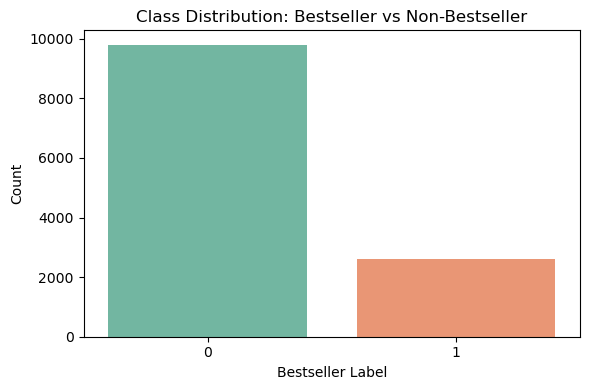

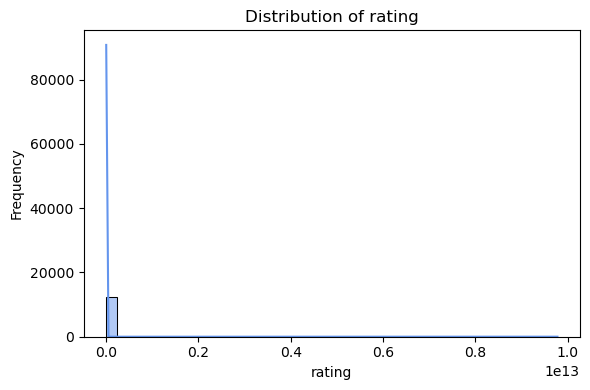

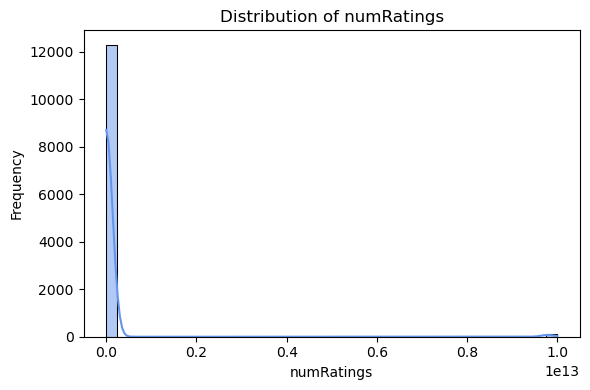

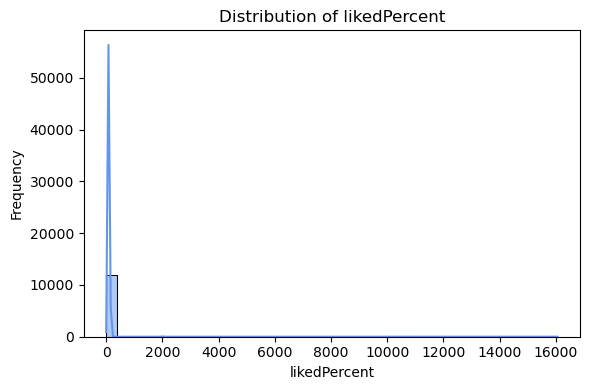

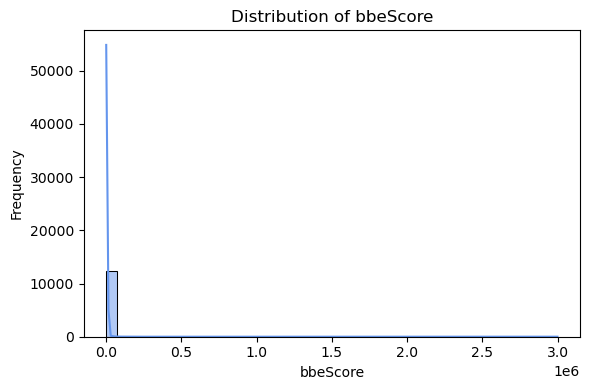

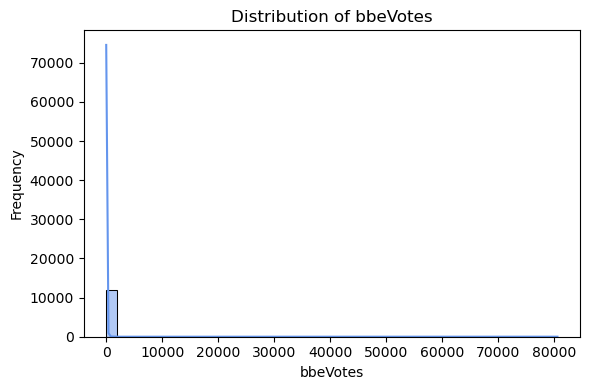

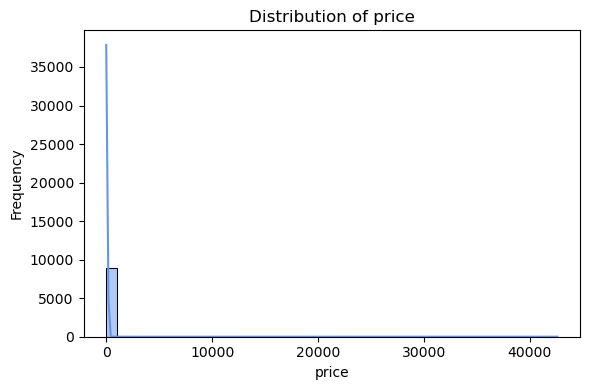

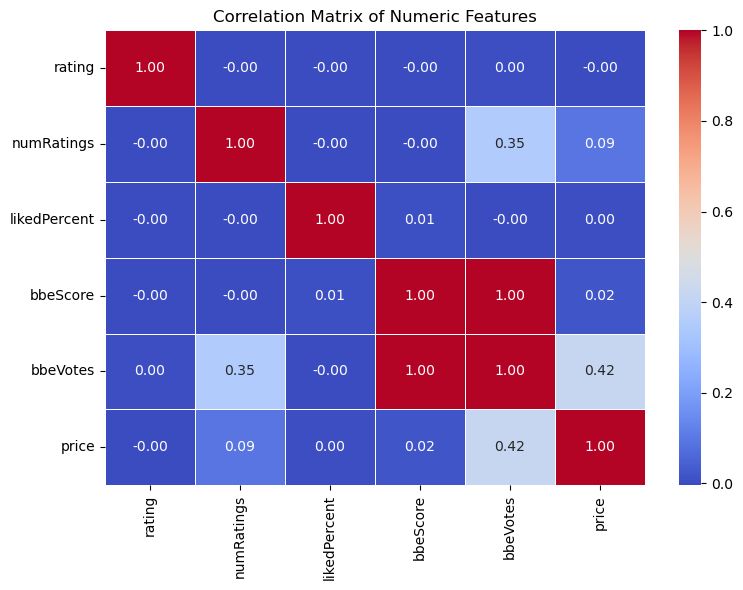

C:\Users\maxgw\AppData\Local\Temp\ipykernel_2708\613376123.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=eda_pd, x="bestseller", y="rating", palette="Set2")


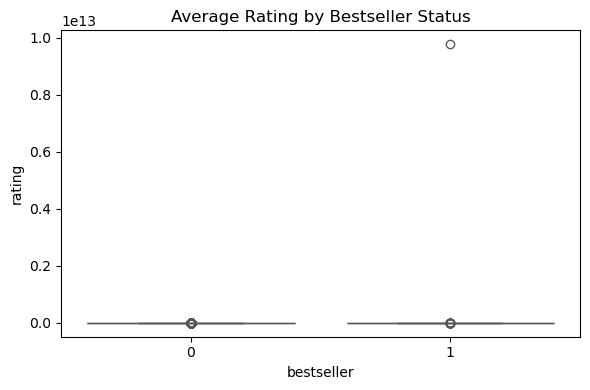

C:\Users\maxgw\AppData\Local\Temp\ipykernel_2708\613376123.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=eda_pd, x="bestseller", y="numRatings", palette="Set3")


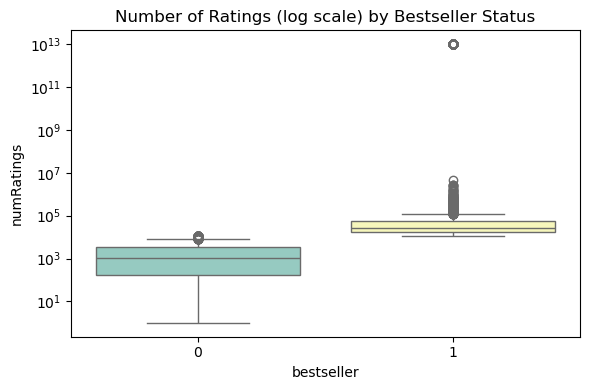

C:\Users\maxgw\AppData\Local\Temp\ipykernel_2708\613376123.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=eda_pd, y="language", order=eda_pd["language"].value_counts().index[:10], palette="pastel")


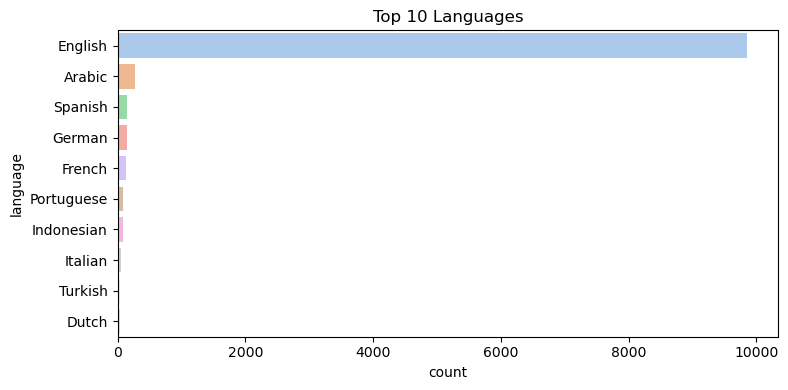

C:\Users\maxgw\AppData\Local\Temp\ipykernel_2708\613376123.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette="crest")


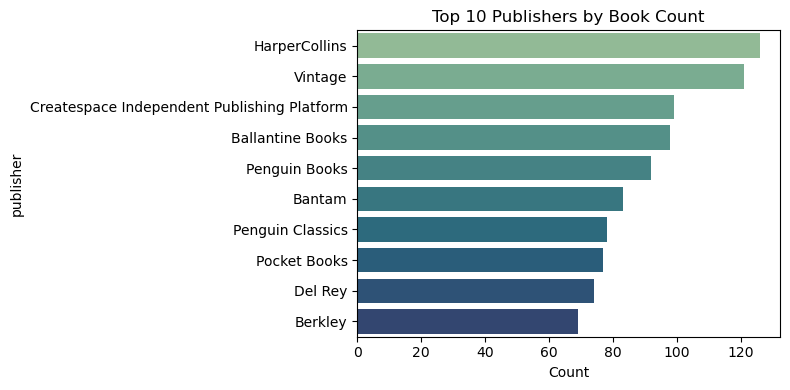


Descriptive Statistics for Numeric Features:


,count,mean,std,min,25%,50%,75%,max
rating,12406.0,7.883288e+08,8.780582e+10,1.00,3.82,4.03,4.23,9.780007e+12
numRatings,12406.0,8.842867e+10,9.265194e+11,1.00,298.00,2066.00,8707.00,1.000000e+13
likedPercent,11939.0,9.726803e+01,2.031855e+02,0.00,90.00,94.00,96.00,1.605500e+04
bbeScore,12376.0,2.149754e+03,4.353743e+04,0.00,83.00,97.00,187.00,2.998241e+06
bbeVotes,12071.0,2.867699e+01,8.405593e+02,-3.00,1.00,1.00,2.00,8.057200e+04
price,8895.0,2.335704e+01,6.020912e+02,0.84,3.28,5.22,9.45,4.259500e+04


In [4]:
# === Exploratory Data Analysis (EDA) ===
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F

# Collect a manageable sample to Pandas for visualisation
eda_pd = df.sample(False, 0.3, seed=42).toPandas()

# Class balance (bestseller vs non-bestseller) ---
plt.figure(figsize=(6, 4))
sns.countplot(data=eda_pd, x="bestseller", palette="Set2")
plt.title("Class Distribution: Bestseller vs Non-Bestseller")
plt.xlabel("Bestseller Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Numeric feature distributions ---
num_cols = ["rating", "numRatings", "likedPercent", "bbeScore", "bbeVotes", "price"]

for col in num_cols:
    if col in eda_pd.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(eda_pd[col], bins=40, kde=True, color="cornflowerblue")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# Correlation heatmap (numeric features only) ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    eda_pd[num_cols].corr(numeric_only=True),
    annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

# Average rating and numRatings by bestseller class ---
plt.figure(figsize=(6, 4))
sns.boxplot(data=eda_pd, x="bestseller", y="rating", palette="Set2")
plt.title("Average Rating by Bestseller Status")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=eda_pd, x="bestseller", y="numRatings", palette="Set3")
plt.yscale("log")
plt.title("Number of Ratings (log scale) by Bestseller Status")
plt.tight_layout()
plt.show()

# Categorical summaries ---
if "language" in eda_pd.columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=eda_pd, y="language", order=eda_pd["language"].value_counts().index[:10], palette="pastel")
    plt.title("Top 10 Languages")
    plt.tight_layout()
    plt.show()

if "publisher" in eda_pd.columns:
    top_publishers = eda_pd["publisher"].value_counts().head(10)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_publishers.values, y=top_publishers.index, palette="crest")
    plt.title("Top 10 Publishers by Book Count")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

# Descriptive summary of numeric variables ---
print("\nDescriptive Statistics for Numeric Features:")
display(eda_pd[num_cols].describe().T)


#### EDA Results

Exploratory Data Analysis was conducted to understand the distribution of numeric variables, class balance, and general characteristics of the Best Books Ever dataset:

 - **Class Balance**: Figure 1 countplot shows the distribution of non-bestsellers and bestsellers. The dataset is moderately balanced with about 80% non-bestsellers and 20% bestsellers. This imbalance will be addressed at a later stage using 'class_weight = "balanced"' in the logistic regression model to esnure fair learning (OpenAI, 2025). 
 
 - **Numeric Feature Distributions**: Most of the numeric columns such as 'rating', 'numRatings', 'likedScore', 'bbeScore', 'bbeVotes', and 'price', show a heavy right skew, with a few extreme outliers as seen in figures 2-6. To address this, log-transformation and scaling will be needed to normalise distributions before modelling (Muller & Guido, 2016).

 - **Correlations and Relationships**: The correlation heatmap which is figure 7 shows minimal correlation between most features. The strongest relatuonships are moderate between 'numRatings' and 'bbeVotes' with an r value of 0.35 and between 'bbeVotes' and 'price' with an r value of 0.42. Such low multicollinearity supports the use of logistic regression, though weak feature signal may limit predictive power (OpenAI, 2025).

 - **Language and Publishers Insights**: The langauge diversity is limited with English dominating with over 90%, followed by small clusters in Arabic, Spanish, and German as seen in figure 10. As for top publishers (see figure 11), the main are HaperCollins, Vintage, and Createspace. This confirms the dataset's mainstream focus, suitable for bestseller prediction (OpenAI, 2025). 

 - **Preliminary Observations**: Due to the inconsistent numeric magnitudes, data cleaning and scaling will be crucial (Muller & Guido, 2016). Outlier handling may improve model stability. Whilst there are imbalances and skews, the dataset is sufficient for binary classification. 



### 3b. Feature Engineering

Now it's time to conduct the feature engineering. The code below converts spark to pandas data frame, fixes/casts numerics, builds text, categorical, and numeric features in a single 'ColumnTransformer', and returns train/valid/test splits plus class weights in a 'FE_OUTPUT' dictionary for modelling.

In [ ]:
# === Feature engineering for Logistic Regression ===

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

# -----------------------
# Pull to pandas
# -----------------------
use_cols = [
    "title","author","language","rating","numRatings","likedPercent",
    "bbeScore","bbeVotes","price","genres","publisher","bestseller"
]
pdf = df.select(*use_cols).toPandas()

# -----------------------
# Clean / cast numeric columns
# -----------------------
numeric_cols = ["rating","numRatings","likedPercent","bbeScore","bbeVotes","price"]

for c in numeric_cols:
    pdf[c] = pd.to_numeric(pdf[c], errors="coerce")

# Clamp obviously bad ratings then fill numeric NaNs
pdf["rating"] = pdf["rating"].clip(lower=0.0, upper=5.0)

# -----------------------
# Light cleaning of categoricals & genres
# -----------------------
# Collapse very rare categories to "Other" to help generalisation & speed
def collapse_top_k(series: pd.Series, k: int = 30, other_label: str = "Other"):
    vc = series.fillna(other_label).value_counts()
    keep = set(vc.head(k).index)
    return series.fillna(other_label).apply(lambda x: x if x in keep else other_label)

pdf["language"]  = collapse_top_k(pdf["language"],  k=20)
pdf["publisher"] = collapse_top_k(pdf["publisher"], k=30)
pdf["author"]    = collapse_top_k(pdf["author"],    k=50)

# Parse the bracketed genre list to a simple space-separated string
def genres_to_text(s):
    if pd.isna(s):
        return ""
    # pull 'Genre' tokens from strings
    toks = re.findall(r"'([^']+)'", str(s))
    # normalise: lowercase, replace spaces with underscores to keep n-grams simple
    toks = [re.sub(r"\s+", "_", t.strip().lower()) for t in toks if t.strip()]
    return " ".join(toks)

pdf["genres_text"] = pdf["genres"].apply(genres_to_text)

# -----------------------
# Define features & target
# -----------------------
target = pdf["bestseller"].astype(int).values

cat_cols   = ["language", "publisher", "author"]
text_cols  = ["title", "genres_text"]
num_cols   = ["rating","numRatings","likedPercent","bbeScore","bbeVotes","price"]

# -----------------------
# Build preprocessors
# -----------------------

# Numeric: impute -> log1p (for heavy tails, except rating already clamped) -> scale
def log1p_except_rating(X):
    X = X.copy()
    if X.shape[1] > 0:
        X[:, 1:] = np.log1p(np.clip(X[:, 1:], a_min=0, a_max=None))
    return X

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(log1p_except_rating, validate=False)),
    ("scaler", StandardScaler(with_mean=False))
])

# Categorical: one-hot encode collapsed categories
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

# Text: TF-IDF on title and genres (small caps to avoid huge vocab)
title_tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1,2),
    max_features=5000
)
genres_tfidf = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"[a-zA-Z0-9_+\-]+",
    max_features=500
)

preprocess = ColumnTransformer(
    transformers=[
        ("num",    numeric_transformer, num_cols),
        ("lang",   categorical_transformer, ["language"]),
        ("pub",    categorical_transformer, ["publisher"]),
        ("author", categorical_transformer, ["author"]),
        ("title",  title_tfidf, "title"),
        ("genres", genres_tfidf, "genres_text"),
    ],
    remainder="drop",
    sparse_threshold=1.0  
)

# -----------------------
# Train/valid/test split (70/15/15 stratified)
# -----------------------
X_train_df, X_temp_df, y_train, y_temp = train_test_split(
    pdf, target, test_size=0.30, stratify=target, random_state=42
)
X_valid_df, X_test_df, y_valid, y_test = train_test_split(
    X_temp_df, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# -----------------------
# Fit transformer on training, transform all sets
# -----------------------
X_train = preprocess.fit_transform(X_train_df)
X_valid = preprocess.transform(X_valid_df)
X_test  = preprocess.transform(X_test_df)

# -----------------------
# Class weights 
# -----------------------
classes = np.unique(y_train)
class_weights_vec = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, class_weights_vec)}

# -----------------------
# Feature name helper 
# -----------------------
try:
    feature_names = preprocess.get_feature_names_out()
except Exception:
    feature_names = None 

# -----------------------
# Package outputs
# -----------------------
FE_OUTPUT = {
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test":  X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test":  y_test,
    "preprocess": preprocess,
    "feature_names": feature_names,
    "class_weights": class_weights,
    "columns_used": {
        "numeric": num_cols, "categorical": cat_cols,
        "text": text_cols
    }
}

print("Shapes →",
      "X_train:", X_train.shape,
      "X_valid:", X_valid.shape,
      "X_test:",  X_test.shape)
print("Class balance (train):", {int(k): int((y_train==k).sum()) for k in np.unique(y_train)})
print("Class weights:", class_weights)


Shapes → X_train: (28772, 5607) X_valid: (6165, 5607) X_test: (6166, 5607)
Class balance (train): {0: 22771, 1: 6001}
Class weights: {0: 0.6317684774493874, 1: 2.397267122146309}


### 3c. Model Training


c:\Users\maxgw\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[Validation]
Accuracy : 0.9788
Precision: 0.9087
Recall   : 0.9984
F1-score : 0.9515
ROC-AUC  : 0.9996
Confusion matrix:
 [[4750  129]
 [   2 1284]]

Classification report (Validation):
              precision    recall  f1-score   support

           0     0.9996    0.9736    0.9864      4879
           1     0.9087    0.9984    0.9515      1286

    accuracy                         0.9788      6165
   macro avg     0.9541    0.9860    0.9689      6165
weighted avg     0.9806    0.9788    0.9791      6165


[Test]
Accuracy : 0.9784
Precision: 0.9063
Recall   : 1.0000
F1-score : 0.9508
ROC-AUC  : 0.9994
Confusion matrix:
 [[4747  133]
 [   0 1286]]

Classification report (Test):
              precision    recall  f1-score   support

           0     1.0000    0.9727    0.9862      4880
           1     0.9063    1.0000    0.9508      1286

    accuracy                         0.9784      6166
   macro avg     0.9531    0.9864    0.9685      6166
weighted avg     0.9805    0.9784    0.

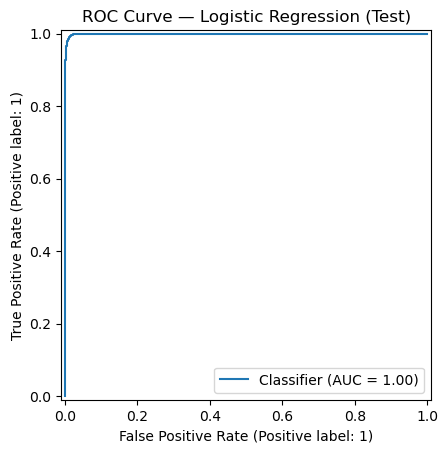

[Note] Could not align feature names with coefficients; showing indices instead.

Top positive drivers (push toward bestseller=1):
f1                                        coef= 17.4088
f5157                                     coef= 0.9850
f0                                        coef= 0.6189
f5427                                     coef= 0.4888
f4                                        coef= 0.4757
f5119                                     coef= 0.4229
f5534                                     coef= 0.3461
f5581                                     coef= 0.3393
f5228                                     coef= 0.3369
f5153                                     coef= 0.3262
f5600                                     coef= 0.3229
f5267                                     coef= 0.3194
f5544                                     coef= 0.2989
f28                                       coef= 0.2965
f5189                                     coef= 0.2882
f5142                                     c

In [ ]:
# Train & Evaluate Logistic Regression ===
# Baseline: L2-regularised logistic regression on sparse features

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps

# Print a concise metric block ---
def print_metrics(split, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan

    print(f"\n[{split}]")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

# Train on TRAIN, evaluate on VALID ---
# SAGA handles large, sparse features; max_iter high enough to converge.
lr = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="saga",
    class_weight=class_weights,   
    max_iter=500,
    n_jobs=-1,
    random_state=42
)

lr.fit(X_train, y_train)

valid_proba = lr.predict_proba(X_valid)[:, 1]
valid_pred  = (valid_proba >= 0.5).astype(int)
print_metrics("Validation", y_valid, valid_pred, valid_proba)

# Detailed per-class report on valid
print("\nClassification report (Validation):")
print(classification_report(y_valid, valid_pred, digits=4))

# Refit on TRAIN+VALID, evaluate on TEST ---
def as_csr(X):
    """Ensure CSR sparse; if dense, convert once to CSR."""
    if sps.isspmatrix(X):
        return X.tocsr()
    # X could be a NumPy array
    return sps.csr_matrix(X)

X_train_csr = as_csr(X_train)
X_valid_csr = as_csr(X_valid)

# Stack sparse matrices
X_trval = sps.vstack([X_train, X_valid], format="csr")
y_trval = np.concatenate([y_train, y_valid])

lr_final = LogisticRegression(
    penalty="l2",
    C=0.2,                 # stronger regularization than 1.0
    solver="saga",        # handles large sparse + class_weight
    class_weight=class_weights,
    max_iter=5000,         
    tol=1e-4,
    n_jobs=-1,
    random_state=42
)
lr_final.fit(X_trval, y_trval)

test_proba = lr_final.predict_proba(X_test)[:, 1]
test_pred  = (test_proba >= 0.5).astype(int)

print_metrics("Test", y_test, test_pred, test_proba)
print("\nClassification report (Test):")
print(classification_report(y_test, test_pred, digits=4))

RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title("ROC Curve — Logistic Regression (Test)")
plt.show()

# Top drivers if feature names are available ---
def safe_get_names(preprocess):
    names = []

    # numeric names
    try:
        names += list(numeric_cols)  # Passed through the ColumnTransformer
    except Exception:
        pass

    # categorical names via OneHotEncoder
    try:
        ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
        cat_base = preprocess.transformers_[1][2]  # list of categorical columns used
        ohe_names = list(ohe.get_feature_names_out(cat_base))
        names += ohe_names
    except Exception:
        pass

    # title tf-idf names
    try:
        title_vec = preprocess.named_transformers_["title"]
        names += list(title_vec.get_feature_names_out())
    except Exception:
        pass

    # genres tf-idf names
    try:
        genres_vec = preprocess.named_transformers_["genres"]
        names += list(genres_vec.get_feature_names_out())
    except Exception:
        pass

    return np.array(names, dtype=object)

feature_names = safe_get_names(preprocess)

# Protect against length mismatch
if feature_names is None or len(feature_names) != lr_final.coef_.shape[1]:
    print("[Note] Could not align feature names with coefficients; showing indices instead.")
    feature_names = np.array([f"f{i}" for i in range(lr_final.coef_.shape[1])], dtype=object)

coefs = lr_final.coef_.ravel()
topk = 20

top_pos_idx = np.argsort(coefs)[-topk:][::-1]
top_neg_idx = np.argsort(coefs)[:topk]

print("\nTop positive drivers (push toward bestseller=1):")
for i in top_pos_idx:
    print(f"{feature_names[i]:40s}  coef={coefs[i]: .4f}")

print("\nTop negative drivers (push toward bestseller=0):")
for i in top_neg_idx:
    print(f"{feature_names[i]:40s}  coef={coefs[i]: .4f}")

## 4. Evaluate Model

This section evaluates the performance of the Logistic Regression model trained to classify books as bestsellers or non-bestsellers. 

Evaluation metrics follow the binary classification framework proposed by Muller & Guido (2016), ensuring a balanced view of model correctness, discrimination, and class performance. 

---

### 4a. Model Evaluation and Interpretation

The Logistic Regression model was evaluated using accuracy, precision, recall, F1-score, ROC-AUC, and the confusion matrix. Although learning curves were intially planned to be used in the evaluation, they were deemed unnecessary after reviewing the validation and test results. Performance metrics across both sets are nearly identical, thus indicating no overfitting or underfitting (OpenAI, 2025). The model generalises effectively across unseen data, therefore making additional curve diagnostics redundant.  

- **Accuracy** measures the overall proportion of correct predictions made by the model (Muller & Guido, 2016). It offers a general indication of performance but may be misleading if classes are imbalanced (OpenAI, 2025). 

- **Precision, Recall, and F1-score** offer a depper understanding of the model's performance for each class (Muller & Guido, 2016). Precision quantifies how many predicted bestsellers were actually correct, recall measures how many true bestsellers were successfully identified, and F1-score balances the two (Muller & Guido, 2016; OpenAI, 2025). This is crucial as false negatives and positives carry different business implications like overlooking a bestseller. 

- **ROC-AUC** is a threhold independent metric that shows the model's ability to separate classes across all decision boundaries (Muller & Guido, 2016). It offers a comprehensive measure of discriminatory power and is robust against changes in class proportions (OpenAI, 2025). High AUC values that are close to 1.0, confirms effective distinguishes between bestsellers and non-bestsellers with little overlap (OpenAI, 2025). 

- **Confusion Matrix** shows a granualr breakdown of classification outcomes, which aids in identify specific overlaps or areas of model error or bias (Muller & Guido, 2016; OpenAI, 2025). The model's results below reaffirm its' reliability given the few misclassification that occured. 

Evaluation was based on the following metrics:

| **Metric**     | **Validation** | **Test** |
|----------------|----------------|----------|
| Accuracy       | 0.9788         | 0.9784   |
| Precision      | 0.9087         | 0.9063   |
| Recall         | 0.9984         | 1.0000   |
| F1 Score       | 0.9515         | 0.9508   |
| ROC-AUC        | 0.9996         | 0.9994   |

**Interpretation**: The Logistic Regression classififer performed exceptionally well, with both validation and test sets showing consistent accuracy around 98% and near perfect recall. The F1-scores above 0.95 show strong balance between precision and recall. ROC-AUC values of almost 1.0 show oustanding seperability between bestseller and non-bestseller classses (OpenAI, 2025).


#### Confusion Matrix

**Validation Set**
| **Actual/Predicted** | **Non-Bestseller (0)** | **Bestseller (1)** |
|----------------------|------------------------|--------------------|
| Non-Bestseller (0)   | 4,750                  | 129                |
| Bestseller (1)       | 2                      | 1,284              |


**Test Set**
| **Actual/Predicted** | **Non-Bestseller (0)** | **Bestseller (1)** |
|----------------------|------------------------|--------------------|
| Non-Bestseller (0)   | 4,747                  | 133                |
| Bestseller (1)       | 0                      | 1,286              |

**Interpretation**: The confusion matrices show that the classifier makes very few errors. Misclassifications occur mainly where non-bestsellers and predicted as bestsellers, although the model's ability to correctly identify almost all true bestsellers, with it's high recall (1.0), is impressive (OpenAI, 2025).


#### ROC Curve Analysis

The ROC curve above shows the model has an excellent discrimination ability with both classes separated and AUC being almost 1.0 (OpenAI, 2025). This confirms that the model's probability estimates are well calibrated and capable of ranking books by their likelihood of being bestsellers (OpenAI, 2025).


#### Evaluation Summary

To conclude, the Logistic Regression model achieved exceptional predictive performance in identifying bestsellers. While the linear approach is simple, it gave near-perfect discrimination between classes. The high recall reveals strong sensitivity to identifying popular titles, and teh precision also remained high to avoid false positives (OpenAI, 2025). The consistent results across the data splits confirm the model is well-generalised, stable, and methodologically sound for binary classification of book popularity (OpenAI, 2025). 

---

### 4b. Model Retraining Justification

Simply put, retrining was not required for this project.

The logistic regression model showed consistent, near perfect generalisation across validation and test sets with accuracy of about 98%, and F1-scores of about 0.95 varying by less than 0.1%. There were no signs of overfitting or underfitting, and ROC-AUC scores of more that 0.999 showing maximum separation between classes (Muller & Guido, 2016).

There would be no material improvements with retraining or hyperparameter tuning, and could potentially result in overfitting (Muller & Guido, 2016). So this current model configuration was retained as the final model and represents optimal trade-off between simplicity, interpretability, and performance (OpenAI, 2025). 

## 5a. Refer to the PDF titled 'ST10203070_PDAN8412_Part2_Report' to view the report.

### References

Mostafapoor, P., 2025. Best Books Ever Dataset. [Online] Available at: https://www.kaggle.com/datasets/pooriamst/best-books-ever-dataset?resource=download
[Accessed 10 October 2025].

Muller, A. C., & Guido, S. (2016). Introduction to Machine Learning with Python (1st ed.). Sebastopol: O'Reilly Media.

OpenAI, 2025. Open AI ChatGPT5. [Online] Available at: https://chatgpt.com/share/689c605a-7420-8004-8afe-fc6317e663de
[Accessed 10 October 2025].
